In [1]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


## Step 1) 데이터 준비와 확인

In [2]:
import pandas as pd

train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## Step 2) 데이터로더 구성
---
* 데이터의 중복 제거
* NaN 결측치 제거
* 한국어 토크나이저로 토큰화
* 불용어(Stopwords) 제거
* 사전word_to_index 구성
* 텍스트 스트링을 사전 인덱스 스트링으로 변환
* X_train, y_train, X_test, y_test, word_to_index 리턴

In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any')
    
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [4]:
print(f'X_train 개수: {len(X_train)}, X_test 개수: {len(X_test)}')
print(f'y_train 개수: {len(y_train)}, y_test 개수: {len(y_test)}')

X_train 개수: 146182, X_test 개수: 49157
y_train 개수: 146182, y_test 개수: 49157


In [5]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [6]:
# 문장 1개와 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
#[1:]를 통해 <BOS>를 제외
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [7]:
print(X_train[2])
print('라벨:', y_train[2])
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[2]))

[24, 205, 2]
라벨: 0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  3


2 번째 리뷰는 추천한다는 글로 긍정(1) 인데 라벨링이 0으로 되어있음.

In [8]:
print(get_decoded_sentence(X_train[0], index_to_word))

더 빙 . . 진짜 짜증 나 네요 목소리


In [9]:
print(X_train[0])

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]


## Step 3) 모델 구성을 위한 데이터 분석 및 가공
---
* 데이터셋 내 문장 길이 분포
* 적절한 최대 문장 길이 지정
* keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [10]:
total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다.
print('문장길이 평균: ', np.mean(num_tokens))
print('문장길이 최대: ', np.max(num_tokens))
print('문장길이 표준편차: ', np.std(num_tokens))

# 최대 길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) + 2.5*np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen:', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함.'.format(np.sum(num_tokens < max_tokens)/len(num_tokens)))

문장길이 평균:  15.96940191154864
문장길이 최대:  116
문장길이 표준편차:  12.843571191092
pad_sequences maxlen: 48
전체 문장의 0.9548784420929768%가 maxlen 설정값 이내에 포함.


In [11]:
import tensorflow as tf
X_train_pre = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=maxlen)
X_test_pre = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=maxlen)
print(f'X_train_pre: {X_train_pre.shape}')
print(f'X_test_pre: {X_test_pre.shape}')

X_train_pre: (146182, 48)
X_test_pre: (49157, 48)


In [12]:
X_train_post = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                       value=word_to_index['<PAD>'],
                                                       padding='post',
                                                       maxlen=maxlen)
X_test_post = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index['<PAD>'],
                                                       padding='post',
                                                       maxlen=maxlen)
print(f'X_train_post: {X_train_post.shape}')
print(f'X_test_post: {X_test_post.shape}')

X_train_post: (146182, 48)
X_test_post: (49157, 48)


In [13]:
print('<X_train_pre>\n')

for i in range(4):
    label = y_train[i]
    encode = X_train_pre[i]
    decode = get_decoded_sentence(X_train_pre[i], index_to_word)
    print(f'label: {label}\n\
    encode: {encode}\n\
    decode: {decode}')

<X_train_pre>

label: 0
    encode: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0  32  74 919   4   4  39 228  20  33 748]
    decode: <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 아 더 빙 . . 진짜 짜증 나 네요 목소리
label: 1
    encode: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0 1028    4   11  519  549  687    5  120    4   70 1639
   52  925 1006   15   44  391]
    decode: <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 흠 . .. 포스터 보고 초딩 영화 줄 . ... 오버 연기 조차 가볍 지 않 구나
labe

In [14]:
print('<X_train_post>\n')

for i in range(4):
    label = y_train[i]
    encode = X_train_post[i]
    decode = get_decoded_sentence(X_train_post[i], index_to_word)
    print(f'label: {label}\n\
    encode: {encode}\n\
    decode: {decode}')

<X_train_post>

label: 0
    encode: [ 32  74 919   4   4  39 228  20  33 748   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]
    decode: 더 빙 . . 진짜 짜증 나 네요 목소리 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
label: 1
    encode: [1028    4   11  519  549  687    5  120    4   70 1639   52  925 1006
   15   44  391    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]
    decode: . .. 포스터 보고 초딩 영화 줄 . ... 오버 연기 조차 가볍 지 않 구나 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

## Step 4) 모델 구성 및 validation set 구성
* train set(80 %)과 val set(20%) 구분
* 3가지 모델 사용
    1. Recurrent Neural Network(RNN)
    2. 1-D Convolution Neural Network(1-D CNN)
    3. GlobalMaxPooling1D

In [15]:
print(len(X_train_post)*0.2, len(X_test_pre)*0.2)

29236.4 9831.400000000001


In [16]:
X_val_post = X_train_post[:23389]
X_val_pre = X_train_pre[:23389]
X_train_post = X_train_post[23389:]
X_train_pre = X_train_pre[23389:]

print(len(X_val_post), len(X_val_pre), len(X_train_post), len(X_train_pre))

23389 23389 122793 122793


In [17]:
y_val = y_train[:23389]
y_train = y_train[23389:]
print(len(y_val), len(y_train))

23389 122793


In [18]:
# RNN
vocab_size = 10000
word_vector_dim = 4

model_rnn = tf.keras.Sequential()
model_rnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None, )))
model_rnn.add(tf.keras.layers.LSTM(8))
model_rnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_rnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 4)           40000     
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 416       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 40,497
Trainable params: 40,497
Non-trainable params: 0
_________________________________________________________________


In [19]:
# 1D CNN
vocab_size = 10000
word_vector_dim = 4

model_1dcnn = tf.keras.Sequential()
model_1dcnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None, )))
model_1dcnn.add(tf.keras.layers.Conv1D(16,7, activation='relu'))
model_1dcnn.add(tf.keras.layers.MaxPooling1D(5))
model_1dcnn.add(tf.keras.layers.Conv1D(16,7, activation='relu'))
model_1dcnn.add(tf.keras.layers.GlobalMaxPooling1D())
model_1dcnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_1dcnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_1dcnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 4)           40000     
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          464       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [20]:
# GlobalMaxPooling1D

vocab_size = 10000 
word_vector_dim = 4  

model_g = tf.keras.Sequential()
model_g.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_g.add(tf.keras.layers.GlobalMaxPooling1D())
model_g.add(tf.keras.layers.Dense(8, activation='relu'))
model_g.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_g.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 4)           40000     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 40,049
Trainable params: 40,049
Non-trainable params: 0
_________________________________________________________________


RNN, 1D-CNN, Globalmaxpooling 모두 파라미터 개수 비슷함

## Step 5) 모델 훈련 개시

__RNN_post padding__

In [21]:
model_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
epochs=20
history_rnn_post = model_rnn.fit(X_train_post,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val_post, y_val),
                    verbose=1)

Epoch 1/20
240/240 [==============================] - 21s 8ms/step - loss: 0.5948 - accuracy: 0.6548 - val_loss: 0.4131 - val_accuracy: 0.8282
Epoch 2/20
240/240 [==============================] - 1s 6ms/step - loss: 0.3678 - accuracy: 0.8444 - val_loss: 0.3617 - val_accuracy: 0.8450
Epoch 3/20
240/240 [==============================] - 1s 6ms/step - loss: 0.3318 - accuracy: 0.8611 - val_loss: 0.3597 - val_accuracy: 0.8412
Epoch 4/20
240/240 [==============================] - 1s 6ms/step - loss: 0.3205 - accuracy: 0.8661 - val_loss: 0.3570 - val_accuracy: 0.8463
Epoch 5/20
240/240 [==============================] - 1s 6ms/step - loss: 0.3147 - accuracy: 0.8685 - val_loss: 0.3608 - val_accuracy: 0.8442
Epoch 6/20
240/240 [==============================] - 1s 6ms/step - loss: 0.3083 - accuracy: 0.8711 - val_loss: 0.3598 - val_accuracy: 0.8429
Epoch 7/20
240/240 [==============================] - 1s 6ms/step - loss: 0.3048 - accuracy: 0.8729 - val_loss: 0.3590 - val_accuracy: 0.8430
Epoch

In [22]:
# 테스트셋으로 평가

results = model_rnn.evaluate(X_test_post,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3773 - accuracy: 0.8420
[0.37727755308151245, 0.8420367240905762]


__RNN_pre padding__

In [23]:
history_rnn_pre = model_rnn.fit(X_train_pre,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val_pre, y_val),
                    verbose=1)

Epoch 1/20
240/240 [==============================] - 1s 6ms/step - loss: 0.2958 - accuracy: 0.8818 - val_loss: 0.3693 - val_accuracy: 0.8454
Epoch 2/20
240/240 [==============================] - 1s 6ms/step - loss: 0.2802 - accuracy: 0.8858 - val_loss: 0.3759 - val_accuracy: 0.8448
Epoch 3/20
240/240 [==============================] - 1s 6ms/step - loss: 0.2752 - accuracy: 0.8874 - val_loss: 0.3720 - val_accuracy: 0.8472
Epoch 4/20
240/240 [==============================] - 1s 6ms/step - loss: 0.2709 - accuracy: 0.8888 - val_loss: 0.3749 - val_accuracy: 0.8463
Epoch 5/20
240/240 [==============================] - 1s 6ms/step - loss: 0.2669 - accuracy: 0.8902 - val_loss: 0.3758 - val_accuracy: 0.8473
Epoch 6/20
240/240 [==============================] - 1s 6ms/step - loss: 0.2631 - accuracy: 0.8906 - val_loss: 0.3859 - val_accuracy: 0.8463
Epoch 7/20
240/240 [==============================] - 1s 6ms/step - loss: 0.2593 - accuracy: 0.8931 - val_loss: 0.3914 - val_accuracy: 0.8472
Epoch 

In [24]:
# 테스트셋으로 평가

results = model_rnn.evaluate(X_test_pre,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4715 - accuracy: 0.8383
[0.47150397300720215, 0.838334321975708]


__1DCNN_post padding__

In [25]:
model_1dcnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
epochs=20
history_1dcnn_post = model_1dcnn.fit(X_train_post,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val_post, y_val),
                    verbose=1)

Epoch 1/20
240/240 [==============================] - 20s 6ms/step - loss: 0.5414 - accuracy: 0.7143 - val_loss: 0.3765 - val_accuracy: 0.8374
Epoch 2/20
240/240 [==============================] - 1s 5ms/step - loss: 0.3481 - accuracy: 0.8519 - val_loss: 0.3466 - val_accuracy: 0.8521
Epoch 3/20
240/240 [==============================] - 1s 5ms/step - loss: 0.3155 - accuracy: 0.8686 - val_loss: 0.3423 - val_accuracy: 0.8521
Epoch 4/20
240/240 [==============================] - 1s 5ms/step - loss: 0.2986 - accuracy: 0.8767 - val_loss: 0.3440 - val_accuracy: 0.8530
Epoch 5/20
240/240 [==============================] - 1s 5ms/step - loss: 0.2860 - accuracy: 0.8824 - val_loss: 0.3489 - val_accuracy: 0.8495
Epoch 6/20
240/240 [==============================] - 1s 5ms/step - loss: 0.2760 - accuracy: 0.8872 - val_loss: 0.3592 - val_accuracy: 0.8481
Epoch 7/20
240/240 [==============================] - 1s 5ms/step - loss: 0.2676 - accuracy: 0.8908 - val_loss: 0.3631 - val_accuracy: 0.8465
Epoch

In [26]:
# 테스트셋으로 평가

results = model_rnn.evaluate(X_test_post,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.7191 - accuracy: 0.5769
[0.7191404700279236, 0.5768862962722778]


__1DCNN_pre padding__

In [27]:
history_1dcnn_pre = model_1dcnn.fit(X_train_pre,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val_pre, y_val),
                    verbose=1)

Epoch 1/20
240/240 [==============================] - 1s 5ms/step - loss: 0.3616 - accuracy: 0.8353 - val_loss: 0.4504 - val_accuracy: 0.8056
Epoch 2/20
240/240 [==============================] - 1s 5ms/step - loss: 0.2992 - accuracy: 0.8671 - val_loss: 0.4567 - val_accuracy: 0.8094
Epoch 3/20
240/240 [==============================] - 1s 5ms/step - loss: 0.2783 - accuracy: 0.8786 - val_loss: 0.4710 - val_accuracy: 0.8097
Epoch 4/20
240/240 [==============================] - 1s 5ms/step - loss: 0.2653 - accuracy: 0.8844 - val_loss: 0.4817 - val_accuracy: 0.8082
Epoch 5/20
240/240 [==============================] - 1s 5ms/step - loss: 0.2547 - accuracy: 0.8904 - val_loss: 0.4995 - val_accuracy: 0.8046
Epoch 6/20
240/240 [==============================] - 1s 5ms/step - loss: 0.2448 - accuracy: 0.8957 - val_loss: 0.5126 - val_accuracy: 0.8050
Epoch 7/20
240/240 [==============================] - 1s 5ms/step - loss: 0.2370 - accuracy: 0.8995 - val_loss: 0.5259 - val_accuracy: 0.8038
Epoch 

In [28]:
# 테스트셋으로 평가

results = model_rnn.evaluate(X_test_pre,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4715 - accuracy: 0.8383
[0.47150397300720215, 0.838334321975708]


__GlobalMaxpooling_post padding__

In [29]:
model_g.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
epochs=20
history_g_post = model_g.fit(X_train_post,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val_post, y_val),
                    verbose=1)

Epoch 1/20
240/240 [==============================] - 1s 4ms/step - loss: 0.6465 - accuracy: 0.6827 - val_loss: 0.5591 - val_accuracy: 0.7620
Epoch 2/20
240/240 [==============================] - 1s 4ms/step - loss: 0.4804 - accuracy: 0.7921 - val_loss: 0.4283 - val_accuracy: 0.8086
Epoch 3/20
240/240 [==============================] - 1s 4ms/step - loss: 0.3952 - accuracy: 0.8286 - val_loss: 0.3925 - val_accuracy: 0.8236
Epoch 4/20
240/240 [==============================] - 1s 4ms/step - loss: 0.3625 - accuracy: 0.8444 - val_loss: 0.3829 - val_accuracy: 0.8270
Epoch 5/20
240/240 [==============================] - 1s 4ms/step - loss: 0.3442 - accuracy: 0.8526 - val_loss: 0.3803 - val_accuracy: 0.8305
Epoch 6/20
240/240 [==============================] - 1s 4ms/step - loss: 0.3316 - accuracy: 0.8586 - val_loss: 0.3815 - val_accuracy: 0.8311
Epoch 7/20
240/240 [==============================] - 1s 4ms/step - loss: 0.3222 - accuracy: 0.8634 - val_loss: 0.3836 - val_accuracy: 0.8314
Epoch 

In [30]:
# 테스트셋으로 평가

results = model_g.evaluate(X_test_post,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4234 - accuracy: 0.8217
[0.42344000935554504, 0.8216733932495117]


__GlobalMaxpooling_pre padding__

In [31]:
history_g_pre = model_g.fit(X_train_pre,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val_pre, y_val),
                    verbose=1)

Epoch 1/20
240/240 [==============================] - 1s 5ms/step - loss: 0.2826 - accuracy: 0.8822 - val_loss: 0.4200 - val_accuracy: 0.8271
Epoch 2/20
240/240 [==============================] - 1s 4ms/step - loss: 0.2817 - accuracy: 0.8828 - val_loss: 0.4220 - val_accuracy: 0.8268
Epoch 3/20
240/240 [==============================] - 1s 4ms/step - loss: 0.2808 - accuracy: 0.8830 - val_loss: 0.4244 - val_accuracy: 0.8262
Epoch 4/20
240/240 [==============================] - 1s 4ms/step - loss: 0.2802 - accuracy: 0.8838 - val_loss: 0.4270 - val_accuracy: 0.8258
Epoch 5/20
240/240 [==============================] - 1s 4ms/step - loss: 0.2794 - accuracy: 0.8836 - val_loss: 0.4274 - val_accuracy: 0.8253
Epoch 6/20
240/240 [==============================] - 1s 4ms/step - loss: 0.2788 - accuracy: 0.8842 - val_loss: 0.4287 - val_accuracy: 0.8259
Epoch 7/20
240/240 [==============================] - 1s 4ms/step - loss: 0.2781 - accuracy: 0.8846 - val_loss: 0.4297 - val_accuracy: 0.8245
Epoch 

In [32]:
# 테스트셋으로 평가

results = model_g.evaluate(X_test_pre,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4470 - accuracy: 0.8179
[0.44704344868659973, 0.8178896307945251]


## Step 6) Loss, Accuracy 그래프 시각화

__RNN_post__

In [33]:
history_dict = history_rnn_post.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


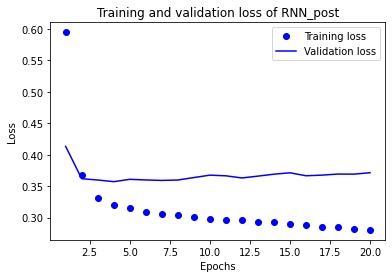

In [34]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss of RNN_post')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

__RNN_pre__

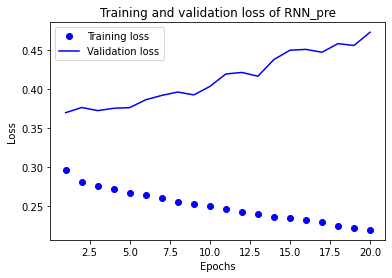

In [35]:
history_dict = history_rnn_pre.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss of RNN_pre')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

__1D-CNN_post__

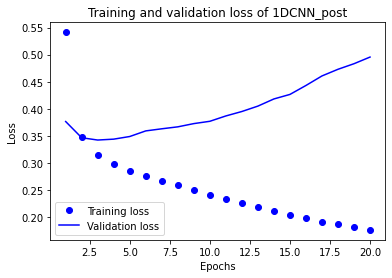

In [36]:
history_dict = history_1dcnn_post.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss of 1DCNN_post')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

__1D-CNN_pre__

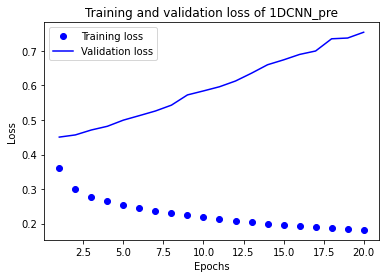

In [37]:
history_dict = history_1dcnn_pre.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss of 1DCNN_pre')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

__Global Maxpooling_post__

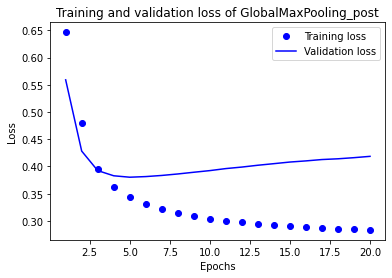

In [38]:
history_dict = history_g_post.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss of GlobalMaxPooling_post')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

__Global Maxpooling_pre__

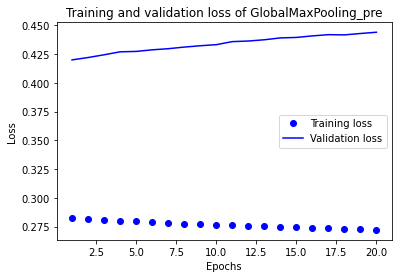

In [39]:
history_dict = history_g_pre.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss of GlobalMaxPooling_pre')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

* 대체로 post padding이 pre padding보다 과적합되는 경향이 약하고
* 

## Step 7) Embedding 레이어 분석

__RNN__

In [40]:
embedding_layer = model_rnn.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 4)


In [41]:
import os
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_rnn.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록. 
vectors = model_rnn.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

gensim에서 제공하는 패키지를 이용해, 위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용

In [42]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['love']
vector

array([-0.5551682 ,  0.36296365,  0.9383114 , -0.29103965], dtype=float32)

In [43]:
word_vectors.similar_by_word("love")

[('이럼', 0.9999022483825684),
 ('룡', 0.9999018311500549),
 ('톰크루즈', 0.999813437461853),
 ('들어온', 0.9996839761734009),
 ('흠뻑', 0.9996685981750488),
 ('들어야', 0.9996529817581177),
 ('한꺼번에', 0.999643087387085),
 ('톡', 0.9995490908622742),
 ('쿠바', 0.9994935989379883),
 ('졸이', 0.999473512172699)]

__1D-CNN__

In [44]:
embedding_layer = model_1dcnn.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 4)


In [45]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_1dcnn.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록. 
vectors = model_1dcnn.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [46]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['love']
vector

array([-0.38105103,  0.26466984, -0.02340504, -0.3324726 ], dtype=float32)

In [47]:
word_vectors.similar_by_word("love")

[('위력', 0.9973259568214417),
 ('브라이언', 0.9969950318336487),
 ('있', 0.9968870878219604),
 ('봣어요', 0.9965648651123047),
 ('두려워', 0.9961284399032593),
 ('영상미', 0.9960184693336487),
 ('만하다', 0.9958329200744629),
 ('호랑이', 0.9956813454627991),
 ('미래', 0.9949573278427124),
 ('삽입곡', 0.994900107383728)]

__Global maxpooling__

In [48]:
embedding_layer = model_1dcnn.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 4)


In [49]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_global.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록. 
vectors = model_g.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [50]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['love']
vector

array([ 0.19742286, -0.28961915,  0.2828887 ,  0.05673553], dtype=float32)

In [51]:
word_vectors.similar_by_word("love")

[('이여', 0.9985957145690918),
 ('생각났', 0.9962134957313538),
 ('이색', 0.9949657320976257),
 ('주의자', 0.993149995803833),
 ('입가', 0.992662787437439),
 ('황홀', 0.9924983382225037),
 ('흐뭇', 0.9922102093696594),
 ('자격', 0.99138343334198),
 ('눈시울', 0.9913116097450256),
 ('각인', 0.9911538362503052)]

## Step 8) Word2Vec 임베딩 활용하여 성능 개선

In [69]:
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['love']
vector     # 300dim의 워드 벡터

array([ 0.10302734, -0.15234375,  0.02587891,  0.16503906, -0.16503906,
        0.06689453,  0.29296875, -0.26367188, -0.140625  ,  0.20117188,
       -0.02624512, -0.08203125, -0.02770996, -0.04394531, -0.23535156,
        0.16992188,  0.12890625,  0.15722656,  0.00756836, -0.06982422,
       -0.03857422,  0.07958984,  0.22949219, -0.14355469,  0.16796875,
       -0.03515625,  0.05517578,  0.10693359,  0.11181641, -0.16308594,
       -0.11181641,  0.13964844,  0.01556396,  0.12792969,  0.15429688,
        0.07714844,  0.26171875,  0.08642578, -0.02514648,  0.33398438,
        0.18652344, -0.20996094,  0.07080078,  0.02600098, -0.10644531,
       -0.10253906,  0.12304688,  0.04711914,  0.02209473,  0.05834961,
       -0.10986328,  0.14941406, -0.10693359,  0.01556396,  0.08984375,
        0.11230469, -0.04370117, -0.11376953, -0.0037384 , -0.01818848,
        0.24316406,  0.08447266, -0.07080078,  0.18066406,  0.03515625,
       -0.09667969, -0.21972656, -0.00328064, -0.03198242,  0.18

 이전 스텝에서 학습했던 모델의 임베딩 레이어를 Word2Vec의 것으로 교체하여 다시 학습

In [ ]:
word2vec.similar_by_word['사랑']

__RNN__

In [ ]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 

# 모델 구성
model_rnn = tf.keras.Sequential()
model_rnn.add(tf.keras.layers.Embedding(vocab_size, 
                                        word_vector_dim, 
                                        # 카피한 임베딩을 여기서 활용
                                        embeddings_initializer=Constant(embedding_matrix),
                                        input_length=maxlen,
                                        # trainable을 True로 주면 Fine-tuning
                                        trainable=True))
model_rnn.add(tf.keras.layers.LSTM(8))
model_rnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_rnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_rnn.summary()

In [ ]:
# 학습 진행
model_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = model_rnn.fit(X_train_post,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val_post, y_val),
                    verbose=1)

In [ ]:
# 테스트셋을 통한 모델 평가
results = model_rnn.evaluate(X_test_post,  y_test, verbose=2)

print(results)

__1D CNN__

In [ ]:
vocab_size = 10000
word_vector_dim = 4

model_1dcnn = tf.keras.Sequential()
model_1dcnn.add(tf.keras.layers.Embedding(vocab_size, 
                                        word_vector_dim, 
                                        embeddings_initializer=Constant(embedding_matrix),
                                        input_length=maxlen,
                                        trainable=True))
model_1dcnn.add(tf.keras.layers.Conv1D(16,7, activation='relu'))
model_1dcnn.add(tf.keras.layers.MaxPooling1D(5))
model_1dcnn.add(tf.keras.layers.Conv1D(16,7, activation='relu'))
model_1dcnn.add(tf.keras.layers.GlobalMaxPooling1D())
model_1dcnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_1dcnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_1dcnn.summary()

In [ ]:
# 학습 진행
model_1dcnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = model_1dcnn.fit(X_train_post,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val_post, y_val),
                    verbose=1)

In [ ]:
# 테스트셋을 통한 모델 평가
results = model_1dcnn.evaluate(X_test_post,  y_test, verbose=2)

print(results)

__Global MaxPooling__

In [ ]:
vocab_size = 10000 
word_vector_dim = 4  

model_g = tf.keras.Sequential()
model_g.add(tf.keras.layers.Embedding(vocab_size, 
                                        word_vector_dim, 
                                        embeddings_initializer=Constant(embedding_matrix),
                                        input_length=maxlen,
                                        trainable=True))
model_g.add(tf.keras.layers.GlobalMaxPooling1D())
model_g.add(tf.keras.layers.Dense(8, activation='relu'))
model_g.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_g.summary()

In [ ]:
# 학습 진행
model_g.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = model_g.fit(X_train_post,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val_post, y_val),
                    verbose=1)

In [ ]:
# 테스트셋을 통한 모델 평가
results = model_g.evaluate(X_test_post,  y_test, verbose=2)

print(results)

* post padding의 overfitting 정도가 낮았기 때문에 모두 post padding된 데이터 셋을 활용해서 평가하였음

### RNN 모델 성능 향상시도

* 단어를 표현하는 워드벡터 차원수 증가시켜서 더 많은 정보 담아보기
* 은닉층과 출력층 사이에 Dropout layer 추가해보기
* Bidirectional LSTM 사용해보기

In [62]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word2vec_file_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)


In [66]:
vector = word_vectors.wv['사랑']
vector.shape

(100,)

In [70]:
vocab_size=10000
word_vector_dim = 100
embedding_matrix=np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [72]:
from tensorflow.keras.initializers import Constant
from tensorflow.keras import layers
vocab_size=10000
word_vector_dim=100

# 모델 구성
model_rnn = tf.keras.Sequential()
model_rnn.add(tf.keras.layers.Embedding(vocab_size,
                                        word_vector_dim, 
                                        embeddings_initializer=Constant(embedding_matrix),
                                        input_length=maxlen,
                                        trainable=True))
model_rnn.add(tf.keras.layers.Bidirectional(layers.LSTM(10, return_sequences=True),
                             input_shape=(5, 10)))
model_rnn.add(tf.keras.layers.Bidirectional(layers.LSTM(10)))
model_rnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_rnn.add(tf.keras.layers.Dropout(.2))
model_rnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_rnn.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 48, 100)           1000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 48, 20)            8880      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 20)                2480      
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 168       
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 1,011,537
Trainable params: 1,011,537
Non-trainable params: 0
____________________________________________

In [73]:
# 학습 진행
model_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history = model_rnn.fit(X_train_post,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val_post, y_val),
                    verbose=1)

Epoch 1/10
240/240 [==============================] - 9s 20ms/step - loss: 0.5590 - accuracy: 0.7040 - val_loss: 0.4294 - val_accuracy: 0.8085
Epoch 2/10
240/240 [==============================] - 4s 15ms/step - loss: 0.4091 - accuracy: 0.8216 - val_loss: 0.3744 - val_accuracy: 0.8327
Epoch 3/10
240/240 [==============================] - 4s 16ms/step - loss: 0.3635 - accuracy: 0.8469 - val_loss: 0.3508 - val_accuracy: 0.8453
Epoch 4/10
240/240 [==============================] - 4s 16ms/step - loss: 0.3353 - accuracy: 0.8607 - val_loss: 0.3435 - val_accuracy: 0.8483
Epoch 5/10
240/240 [==============================] - 4s 15ms/step - loss: 0.3153 - accuracy: 0.8707 - val_loss: 0.3390 - val_accuracy: 0.8509
Epoch 6/10
240/240 [==============================] - 4s 15ms/step - loss: 0.2995 - accuracy: 0.8774 - val_loss: 0.3404 - val_accuracy: 0.8523
Epoch 7/10
240/240 [==============================] - 4s 15ms/step - loss: 0.2890 - accuracy: 0.8837 - val_loss: 0.3399 - val_accuracy: 0.8539

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


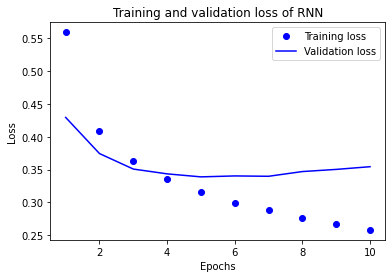

In [74]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss of RNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [75]:
# 테스트셋을 통한 모델 평가
results = model_rnn.evaluate(X_test_post,  y_test, verbose=2)

print(results)

1537/1537 - 7s - loss: 0.3587 - accuracy: 0.8508
[0.358653724193573, 0.8507842421531677]
